## Importing the required libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

In [ ]:
datadf= pd.DataFrame(columns=['data','gender','emotion'])

dirlist= os.listdir('/content/drive/MyDrive/CNN_Project/data/')
count = 0
for i in dirlist:
  file_list = os.listdir('/content/drive/MyDrive/CNN_Project/data/' + i)
  for f in file_list:
    path = '/content/drive/MyDrive/CNN_Project/data/' + i + '/' + f
    nm = f.split('.')[0].split('-')
    emotion = int(nm[2])
    actor = int(nm[-1])

    if int(actor)%2 == 0:
        gender = "female"
    else:
        gender = "male"

    datadf.loc[count] = [path,gender,emotion]
    count += 1

In [ ]:

datadf.head(100)

,data,gender,emotion
0,/content/drive/MyDrive/CNN_Project/data/Actor_...,female,6
1,/content/drive/MyDrive/CNN_Project/data/Actor_...,female,3
2,/content/drive/MyDrive/CNN_Project/data/Actor_...,female,6
3,/content/drive/MyDrive/CNN_Project/data/Actor_...,female,4
4,/content/drive/MyDrive/CNN_Project/data/Actor_...,female,6
...,...,...,...
95,/content/drive/MyDrive/CNN_Project/data/Actor_...,male,4
96,/content/drive/MyDrive/CNN_Project/data/Actor_...,male,8
97,/content/drive/MyDrive/CNN_Project/data/Actor_...,male,7
98,/content/drive/MyDrive/CNN_Project/data/Actor_...,male,8


## Plotting the audio file's waveform and its spectrogram

In [ ]:
filename = datadf.data[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

/content/drive/MyDrive/CNN_Project/data/Actor_11/03-01-02-01-01-01-11.wav


(22050, array([ 7.0949223e-05,  1.2079003e-04,  1.1247222e-04, ...,
        -8.9192872e-05, -9.3600349e-05,  0.0000000e+00], dtype=float32))

In [ ]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


Text(0.5, 0, 'Seconds')

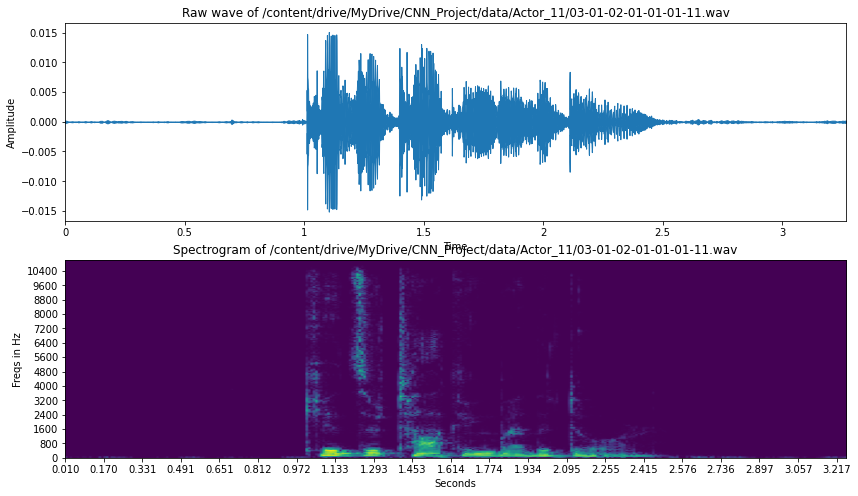

In [ ]:
# Plotting Wave Form and Spectrogram(
    #A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time)
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

## Setting the labels

In [ ]:
label5_list = []
for i in range(len(datadf)):
    if datadf.emotion[i] == 2:
        lb = "_calm"
    elif datadf.emotion[i] == 3:
        lb = "_happy"
    elif datadf.emotion[i] == 4:
        lb = "_sad"
    elif datadf.emotion[i] == 5:
        lb = "_angry"
    elif datadf.emotion[i] == 6:
        lb = "_fearful"    
    
      
    
    # Add gender to the label  
    label5_list.append(datadf.gender[i] + lb)
    
len(label5_list)

1440

In [ ]:

datadf['label'] = label5_list
datadf.head()

,data,gender,emotion,label
0,/content/drive/MyDrive/CNN_Project/data/Actor_...,female,6,female_fearful
1,/content/drive/MyDrive/CNN_Project/data/Actor_...,female,3,female_happy
2,/content/drive/MyDrive/CNN_Project/data/Actor_...,female,6,female_fearful
3,/content/drive/MyDrive/CNN_Project/data/Actor_...,female,4,female_sad
4,/content/drive/MyDrive/CNN_Project/data/Actor_...,female,6,female_fearful


In [ ]:
print (datadf.label.value_counts().keys())

Index(['male_fearful', 'female_fearful', 'female_angry', 'male_angry',
       'male_calm', 'male_happy', 'female_happy', 'female_calm', 'male_sad',
       'female_sad'],
      dtype='object')


## Getting the features of audio files using librosa

In [ ]:
count = 0
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(datadf))):
    X, sample_rate = librosa.load(datadf.data[i], res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5) # path, 
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
    featurelive = mfccs
    data.loc[count,'feature'] = featurelive
    count= count + 1

100%|██████████| 1440/1440 [01:15<00:00, 19.17it/s]


In [ ]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = datadf.label



df3[:5]

In [ ]:
newdf = pd.concat([df3,labels], axis=1)

newdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,label
0,-51.902584,-52.353981,-52.741085,-51.768650,-52.477547,-51.622517,-51.330887,-51.659996,-50.603081,-51.142685,-52.419964,-53.580891,-52.117065,-49.855759,-51.856377,-51.861588,-49.699417,-50.430489,-53.587166,-54.631371,-55.023575,-53.884052,-50.963772,-50.207249,-46.496311,-44.754475,-45.884380,-46.161560,-48.224003,-46.932575,-47.695335,-50.185673,-50.812378,-49.203693,-48.655983,-49.528542,-48.023338,-46.376461,-48.063206,-46.254787,...,-25.778280,-29.300535,-31.860250,-33.540802,-33.845158,-37.254021,-37.995850,-38.110630,-41.999393,-42.264179,-41.996563,-44.192368,-46.438747,-48.432175,-46.078163,-43.903545,-42.903133,-43.608635,-44.554256,-45.194870,-43.807270,-45.325275,-44.903080,-45.917007,-47.138374,-47.504910,-47.793480,-47.954624,-44.243233,-45.562378,-46.703510,-45.953838,-47.489540,-48.091927,-48.895603,-49.874180,-49.468163,-46.761631,-46.996803,female_fearful
1,-50.805885,-50.081211,-48.507507,-48.846657,-49.324673,-50.057331,-49.539688,-47.899948,-48.293575,-48.275047,-48.114109,-47.884197,-46.191811,-47.404667,-50.699387,-49.815456,-48.994301,-48.453224,-46.289795,-46.027767,-46.130924,-49.049213,-49.610332,-50.652691,-50.221718,-49.737225,-49.282692,-48.856365,-48.419590,-52.309616,-51.932777,-51.075863,-48.891209,-48.640915,-50.010700,-49.765278,-50.868599,-51.361324,-50.467678,-50.509087,...,-28.381884,-28.693485,-28.287584,-30.212797,-30.316906,-29.318434,-29.538054,-29.998508,-30.554930,-30.167793,-31.691162,-34.494717,-34.891685,-35.741776,-33.519844,-34.151833,-35.603310,-37.763561,-38.342911,-40.384480,-42.914387,-42.110149,-44.055290,-45.634159,-47.066059,-45.615532,-44.619789,-44.241341,-43.889046,-45.090450,-43.127518,-44.854191,-47.850368,-44.638481,-44.379574,-46.842278,-47.953735,-47.058372,-45.793049,female_happy
2,-42.496696,-40.683510,-39.928288,-40.250160,-40.637547,-40.223694,-40.783562,-40.889065,-40.087563,-40.934109,-42.025078,-42.960873,-43.393501,-42.719418,-42.893303,-42.123989,-41.408108,-40.893990,-39.966778,-39.943764,-39.504189,-40.439430,-39.968399,-39.762138,-38.579411,-38.406616,-38.297062,-36.970558,-36.273911,-36.906879,-35.395191,-34.440140,-34.393276,-34.011753,-33.986118,-34.980862,-38.378170,-38.113205,-40.132450,-39.760010,...,-34.487198,-34.558670,-34.568417,-33.943707,-35.315102,-35.939976,-36.169785,-37.351437,-38.393284,-36.914406,-37.157478,-39.345055,-38.375587,-39.469116,-39.436565,-39.203285,-38.436512,-38.867649,-39.174046,-37.185699,-37.473892,-37.896172,-37.472145,-38.039024,-37.352638,-37.046383,-37.703281,-38.169373,-39.690872,-41.784466,-41.472263,-40.679695,-39.669472,-40.037289,-40.351265,-41.536926,-41.766762,-40.129128,-39.644192,female_fearful
3,-59.254196,-55.769096,-53.499149,-53.206535,-51.857327,-51.743076,-53.126953,-53.163639,-53.088013,-54.972420,-52.746014,-52.072918,-52.828262,-51.359474,-50.730587,-50.929012,-50.067497,-48.487461,-49.765278,-49.355068,-48.961868,-49.730759,-49.795280,-50.999676,-53.039101,-56.675987,-57.383320,-53.619144,-51.364822,-52.131474,-49.508911,-49.515823,-50.912197,-49.816406,-51.001911,-51.632866,-51.382748,-52.125069,-52.022583,-53.765602,...,-43.649010,-44.906754,-44.452969,-46.116142,-46.003071,-47.155441,-49.654964,-49.165489,-49.638386,-52.030205,-52.725056,-50.199600,-49.365704,-49.781490,-49.842957,-49.981697,-49.281448,-50.041824,-49.116856,-48.632725,-47.757149,-48.510857,-48.239361,-47.819405,-47.516251,-46.743546,-50.026306,-49.889347,-50.651325,-52.925991,-52.252792,-50.024021,-50.142239,-50.522766,-51.571918,-50.673416,-51.651291,-52.606575,-50.975716,female_sad
4,-55.819839,-54.076801,-54.816719,-52.090027,-50.501907,-48.636063,-47.764511,-48.701767,-49.845596,-51.277885,-48.619076,-49.108051,-51.254612,-51.097012,-49.873081,-4

In [ ]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

len(rnewdf)

1440

In [ ]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,label
0,-51.902584,-52.353981,-52.741085,-51.768650,-52.477547,-51.622517,-51.330887,-51.659996,-50.603081,-51.142685,-52.419964,-53.580891,-52.117065,-49.855759,-51.856377,-51.861588,-49.699417,-50.430489,-53.587166,-54.631371,-55.023575,-53.884052,-50.963772,-50.207249,-46.496311,-44.754475,-45.884380,-46.161560,-48.224003,-46.932575,-47.695335,-50.185673,-50.812378,-49.203693,-48.655983,-49.528542,-48.023338,-46.376461,-48.063206,-46.254787,...,-25.778280,-29.300535,-31.860250,-33.540802,-33.845158,-37.254021,-37.995850,-38.110630,-41.999393,-42.264179,-41.996563,-44.192368,-46.438747,-48.432175,-46.078163,-43.903545,-42.903133,-43.608635,-44.554256,-45.194870,-43.807270,-45.325275,-44.903080,-45.917007,-47.138374,-47.504910,-47.793480,-47.954624,-44.243233,-45.562378,-46.703510,-45.953838,-47.489540,-48.091927,-48.895603,-49.874180,-49.468163,-46.761631,-46.996803,female_fearful
1,-50.805885,-50.081211,-48.507507,-48.846657,-49.324673,-50.057331,-49.539688,-47.899948,-48.293575,-48.275047,-48.114109,-47.884197,-46.191811,-47.404667,-50.699387,-49.815456,-48.994301,-48.453224,-46.289795,-46.027767,-46.130924,-49.049213,-49.610332,-50.652691,-50.221718,-49.737225,-49.282692,-48.856365,-48.419590,-52.309616,-51.932777,-51.075863,-48.891209,-48.640915,-50.010700,-49.765278,-50.868599,-51.361324,-50.467678,-50.509087,...,-28.381884,-28.693485,-28.287584,-30.212797,-30.316906,-29.318434,-29.538054,-29.998508,-30.554930,-30.167793,-31.691162,-34.494717,-34.891685,-35.741776,-33.519844,-34.151833,-35.603310,-37.763561,-38.342911,-40.384480,-42.914387,-42.110149,-44.055290,-45.634159,-47.066059,-45.615532,-44.619789,-44.241341,-43.889046,-45.090450,-43.127518,-44.854191,-47.850368,-44.638481,-44.379574,-46.842278,-47.953735,-47.058372,-45.793049,female_happy
2,-42.496696,-40.683510,-39.928288,-40.250160,-40.637547,-40.223694,-40.783562,-40.889065,-40.087563,-40.934109,-42.025078,-42.960873,-43.393501,-42.719418,-42.893303,-42.123989,-41.408108,-40.893990,-39.966778,-39.943764,-39.504189,-40.439430,-39.968399,-39.762138,-38.579411,-38.406616,-38.297062,-36.970558,-36.273911,-36.906879,-35.395191,-34.440140,-34.393276,-34.011753,-33.986118,-34.980862,-38.378170,-38.113205,-40.132450,-39.760010,...,-34.487198,-34.558670,-34.568417,-33.943707,-35.315102,-35.939976,-36.169785,-37.351437,-38.393284,-36.914406,-37.157478,-39.345055,-38.375587,-39.469116,-39.436565,-39.203285,-38.436512,-38.867649,-39.174046,-37.185699,-37.473892,-37.896172,-37.472145,-38.039024,-37.352638,-37.046383,-37.703281,-38.169373,-39.690872,-41.784466,-41.472263,-40.679695,-39.669472,-40.037289,-40.351265,-41.536926,-41.766762,-40.129128,-39.644192,female_fearful
3,-59.254196,-55.769096,-53.499149,-53.206535,-51.857327,-51.743076,-53.126953,-53.163639,-53.088013,-54.972420,-52.746014,-52.072918,-52.828262,-51.359474,-50.730587,-50.929012,-50.067497,-48.487461,-49.765278,-49.355068,-48.961868,-49.730759,-49.795280,-50.999676,-53.039101,-56.675987,-57.383320,-53.619144,-51.364822,-52.131474,-49.508911,-49.515823,-50.912197,-49.816406,-51.001911,-51.632866,-51.382748,-52.125069,-52.022583,-53.765602,...,-43.649010,-44.906754,-44.452969,-46.116142,-46.003071,-47.155441,-49.654964,-49.165489,-49.638386,-52.030205,-52.725056,-50.199600,-49.365704,-49.781490,-49.842957,-49.981697,-49.281448,-50.041824,-49.116856,-48.632725,-47.757149,-48.510857,-48.239361,-47.819405,-47.516251,-46.743546,-50.026306,-49.889347,-50.651325,-52.925991,-52.252792,-50.024021,-50.142239,-50.522766,-51.571918,-50.673416,-51.651291,-52.606575,-50.975716,female_sad
4,-55.819839,-54.076801,-54.816719,-52.090027,-50.501907,-48.636063,-47.764511,-48.701767,-49.845596,-51.277885,-48.619076,-49.108051,-51.254612,-51.097012,-49.873081,-4

In [ ]:
rnewdf.isnull().sum().sum()

9

In [ ]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,label
0,-51.902584,-52.353981,-52.741085,-51.768650,-52.477547,-51.622517,-51.330887,-51.659996,-50.603081,-51.142685,-52.419964,-53.580891,-52.117065,-49.855759,-51.856377,-51.861588,-49.699417,-50.430489,-53.587166,-54.631371,-55.023575,-53.884052,-50.963772,-50.207249,-46.496311,-44.754475,-45.884380,-46.161560,-48.224003,-46.932575,-47.695335,-50.185673,-50.812378,-49.203693,-48.655983,-49.528542,-48.023338,-46.376461,-48.063206,-46.254787,...,-25.778280,-29.300535,-31.860250,-33.540802,-33.845158,-37.254021,-37.995850,-38.110630,-41.999393,-42.264179,-41.996563,-44.192368,-46.438747,-48.432175,-46.078163,-43.903545,-42.903133,-43.608635,-44.554256,-45.194870,-43.807270,-45.325275,-44.903080,-45.917007,-47.138374,-47.504910,-47.793480,-47.954624,-44.243233,-45.562378,-46.703510,-45.953838,-47.489540,-48.091927,-48.895603,-49.874180,-49.468163,-46.761631,-46.996803,female_fearful
1,-50.805885,-50.081211,-48.507507,-48.846657,-49.324673,-50.057331,-49.539688,-47.899948,-48.293575,-48.275047,-48.114109,-47.884197,-46.191811,-47.404667,-50.699387,-49.815456,-48.994301,-48.453224,-46.289795,-46.027767,-46.130924,-49.049213,-49.610332,-50.652691,-50.221718,-49.737225,-49.282692,-48.856365,-48.419590,-52.309616,-51.932777,-51.075863,-48.891209,-48.640915,-50.010700,-49.765278,-50.868599,-51.361324,-50.467678,-50.509087,...,-28.381884,-28.693485,-28.287584,-30.212797,-30.316906,-29.318434,-29.538054,-29.998508,-30.554930,-30.167793,-31.691162,-34.494717,-34.891685,-35.741776,-33.519844,-34.151833,-35.603310,-37.763561,-38.342911,-40.384480,-42.914387,-42.110149,-44.055290,-45.634159,-47.066059,-45.615532,-44.619789,-44.241341,-43.889046,-45.090450,-43.127518,-44.854191,-47.850368,-44.638481,-44.379574,-46.842278,-47.953735,-47.058372,-45.793049,female_happy
2,-42.496696,-40.683510,-39.928288,-40.250160,-40.637547,-40.223694,-40.783562,-40.889065,-40.087563,-40.934109,-42.025078,-42.960873,-43.393501,-42.719418,-42.893303,-42.123989,-41.408108,-40.893990,-39.966778,-39.943764,-39.504189,-40.439430,-39.968399,-39.762138,-38.579411,-38.406616,-38.297062,-36.970558,-36.273911,-36.906879,-35.395191,-34.440140,-34.393276,-34.011753,-33.986118,-34.980862,-38.378170,-38.113205,-40.132450,-39.760010,...,-34.487198,-34.558670,-34.568417,-33.943707,-35.315102,-35.939976,-36.169785,-37.351437,-38.393284,-36.914406,-37.157478,-39.345055,-38.375587,-39.469116,-39.436565,-39.203285,-38.436512,-38.867649,-39.174046,-37.185699,-37.473892,-37.896172,-37.472145,-38.039024,-37.352638,-37.046383,-37.703281,-38.169373,-39.690872,-41.784466,-41.472263,-40.679695,-39.669472,-40.037289,-40.351265,-41.536926,-41.766762,-40.129128,-39.644192,female_fearful
3,-59.254196,-55.769096,-53.499149,-53.206535,-51.857327,-51.743076,-53.126953,-53.163639,-53.088013,-54.972420,-52.746014,-52.072918,-52.828262,-51.359474,-50.730587,-50.929012,-50.067497,-48.487461,-49.765278,-49.355068,-48.961868,-49.730759,-49.795280,-50.999676,-53.039101,-56.675987,-57.383320,-53.619144,-51.364822,-52.131474,-49.508911,-49.515823,-50.912197,-49.816406,-51.001911,-51.632866,-51.382748,-52.125069,-52.022583,-53.765602,...,-43.649010,-44.906754,-44.452969,-46.116142,-46.003071,-47.155441,-49.654964,-49.165489,-49.638386,-52.030205,-52.725056,-50.199600,-49.365704,-49.781490,-49.842957,-49.981697,-49.281448,-50.041824,-49.116856,-48.632725,-47.757149,-48.510857,-48.239361,-47.819405,-47.516251,-46.743546,-50.026306,-49.889347,-50.651325,-52.925991,-52.252792,-50.024021,-50.142239,-50.522766,-51.571918,-50.673416,-51.651291,-52.606575,-50.975716,female_sad
4,-55.819839,-54.076801,-54.816719,-52.090027,-50.501907,-48.636063,-47.764511,-48.701767,-49.845596,-51.277885,-48.619076,-49.108051,-51.254612,-51.097012,-49.873081,-4


## Dividing the data into test and train

In [ ]:
#  Stratified Shuffle Split
from sklearn.model_selection import StratifiedShuffleSplit

X = rnewdf.drop(['label'], axis=1)
y = rnewdf.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
y_train.value_counts()

male_fearful      136
female_fearful    134
female_angry      127
male_angry        114
male_calm         112
male_happy        109
female_happy      106
female_calm       106
male_sad          105
female_sad        103
Name: label, dtype: int64

In [ ]:
y_test.value_counts()

female_fearful    34
male_fearful      34
female_angry      31
male_angry        29
male_calm         28
female_happy      27
male_happy        27
male_sad          26
female_sad        26
female_calm       26
Name: label, dtype: int64

In [ ]:
X_train.isna().sum().sum()

0

In [ ]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder


X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
X_train.shape

(1152, 216)

## Changing dimension for CNN model

In [ ]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [ ]:
model = Sequential()
model.add(Conv1D(256, 5,padding='same', input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 216, 256)          1536      
_________________________________________________________________
activation_31 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 216, 128)          163968    
_________________________________________________________________
activation_32 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 27, 128)          

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Epoch 1/700
72/72 [==============================] - 1s 9ms/step - loss: 2.5190 - accuracy: 0.0948 - val_loss: 2.2963 - val_accuracy: 0.1007
Epoch 2/700
72/72 [==============================] - 0s 6ms/step - loss: 2.3336 - accuracy: 0.1110 - val_loss: 2.2816 - val_accuracy: 0.1146
Epoch 3/700
72/72 [==============================] - 0s 6ms/step - loss: 2.3226 - accuracy: 0.0991 - val_loss: 2.2751 - val_accuracy: 0.1493
Epoch 4/700
72/72 [==============================] - 0s 6ms/step - loss: 2.3081 - accuracy: 0.1262 - val_loss: 2.2706 - val_accuracy: 0.1493
Epoch 5/700
72/72 [==============================] - 0s 6ms/step - loss: 2.2895 - accuracy: 0.1297 - val_loss: 2.2679 - val_accuracy: 0.1389
Epoch 6/700
72/72 [==============================] - 0s 6ms/step - loss: 2.2994 - accuracy: 0.1330 - val_loss: 2.2649 - val_accuracy: 0.1667
Epoch 7/700
72/72 [==============================] - 0s 6ms/step - loss: 2.2952 - accuracy: 0.1364 - val_loss: 2.2612 - val_accuracy: 0.1389
Epoch 8/700
7

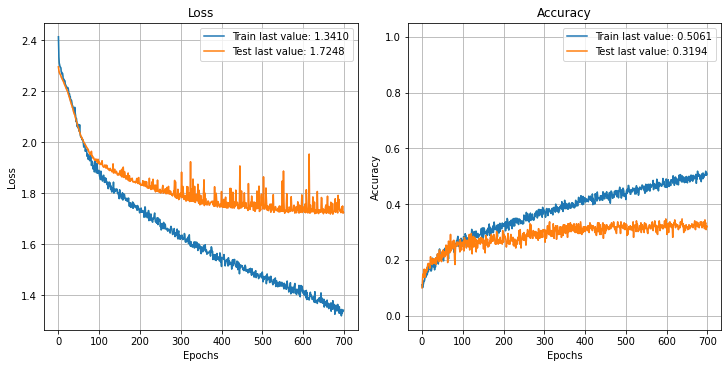

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt


plot_history(cnnhistory)
plt.show()

plt.close()


In [ ]:
score = model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 31.94%


## Saving the model

In [ ]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join('/content/drive/MyDrive/CNN_Project/new model/', 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/MyDrive/CNN_Project/new model/saved_models/Emotion_Voice_Detection_Model.h5 


In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/CNN_Project/new model/saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 31.94%


## Predicting emotions on the test data

In [ ]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

9/9 [==============================] - 0s 3ms/step


In [ ]:
preds

array([[9.8289125e-02, 2.4071902e-01, 3.9780878e-02, ..., 6.6625394e-02,
        1.0475534e-01, 1.2318761e-01],
       [2.8498083e-02, 6.4145438e-02, 4.8679650e-02, ..., 1.4498314e-01,
        1.6318531e-01, 2.9190722e-01],
       [7.9882346e-02, 2.0154160e-02, 6.1003014e-02, ..., 1.5042625e-01,
        1.7638579e-01, 2.2094505e-01],
       ...,
       [2.1360267e-03, 1.5997498e-03, 4.6789828e-03, ..., 1.7542236e-01,
        2.8555569e-01, 1.0260873e-01],
       [1.5859095e-02, 8.8964943e-03, 4.1703749e-02, ..., 8.0629274e-02,
        1.0093921e-01, 3.0008596e-01],
       [2.4665674e-04, 7.1690876e-05, 3.7788093e-04, ..., 3.1763220e-01,
        2.2144477e-01, 1.1771441e-01]], dtype=float32)

In [ ]:
preds1=preds.argmax(axis=1)

In [ ]:
preds1

array([1, 9, 9, 4, 0, 5, 6, 5, 7, 1, 0, 9, 9, 2, 4, 4, 5, 6, 4, 4, 3, 7,
       1, 1, 8, 7, 0, 0, 1, 9, 1, 2, 7, 5, 8, 8, 2, 6, 2, 2, 5, 2, 3, 2,
       3, 5, 6, 5, 5, 5, 4, 9, 4, 3, 2, 5, 7, 2, 1, 0, 8, 5, 2, 6, 0, 7,
       3, 8, 8, 4, 7, 0, 3, 8, 2, 9, 2, 2, 1, 2, 4, 4, 9, 6, 1, 5, 1, 6,
       5, 1, 2, 5, 7, 6, 4, 8, 0, 1, 9, 5, 9, 2, 2, 1, 2, 5, 1, 0, 1, 0,
       5, 8, 3, 1, 0, 4, 6, 1, 9, 7, 6, 1, 8, 6, 0, 5, 8, 1, 1, 3, 2, 9,
       2, 6, 0, 5, 5, 6, 1, 7, 0, 7, 9, 9, 6, 8, 2, 8, 4, 1, 3, 8, 9, 3,
       2, 7, 3, 0, 9, 0, 9, 5, 9, 1, 8, 0, 2, 0, 6, 1, 8, 0, 9, 1, 7, 2,
       0, 0, 6, 3, 5, 2, 7, 0, 0, 6, 0, 6, 7, 9, 4, 5, 4, 8, 6, 2, 6, 1,
       2, 2, 5, 7, 0, 0, 5, 6, 7, 9, 2, 4, 9, 2, 1, 3, 7, 0, 5, 5, 1, 8,
       0, 9, 8, 0, 5, 0, 4, 7, 2, 1, 7, 3, 6, 1, 4, 6, 7, 9, 2, 8, 6, 5,
       5, 4, 2, 8, 5, 3, 2, 6, 2, 3, 7, 1, 6, 1, 7, 3, 7, 7, 1, 3, 7, 2,
       0, 7, 6, 1, 0, 0, 2, 8, 9, 6, 5, 9, 7, 4, 5, 4, 3, 4, 6, 8, 2, 6,
       6, 7])

In [ ]:
abc = preds1.astype(int).flatten()

In [ ]:
predictions = (lb.inverse_transform((abc)))

In [ ]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

preddf.head()

,predictedvalues
0,female_calm
1,male_sad
2,male_sad
3,female_sad
4,female_angry


In [ ]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [ ]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_happy
1,male_fearful
2,male_fearful
3,female_sad
4,female_fearful
5,male_angry
6,male_sad
7,male_fearful
8,male_angry
9,female_sad


In [ ]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [ ]:
finaldf[170:180]

,actualvalues,predictedvalues
170,male_calm,male_happy
171,female_angry,female_angry
172,female_sad,male_sad
173,female_sad,female_calm
174,male_sad,male_fearful
175,female_angry,female_fearful
176,female_calm,female_angry
177,female_angry,female_angry
178,male_fearful,male_calm
179,female_happy,female_happy


In [ ]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,31
female_calm,26
female_fearful,34
female_happy,27
female_sad,26
male_angry,29
male_calm,28
male_fearful,34
male_happy,27


In [ ]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,33
female_calm,34
female_fearful,38
female_happy,19
female_sad,22
male_angry,33
male_calm,31
male_fearful,29
male_happy,23


In [ ]:
finaldf.to_csv('Predictions.csv', index=False)

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [ ]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

31.944444444444443

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

30.957801831214482

In [ ]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[12,  2,  7,  2,  2,  1,  0,  2,  1,  2],
       [ 5, 11,  5,  0,  4,  0,  1,  0,  0,  0],
       [ 5,  4, 12,  6,  4,  0,  0,  2,  0,  1],
       [ 4,  7,  5,  6,  4,  0,  0,  0,  0,  1],
       [ 2,  7,  4,  5,  6,  1,  0,  0,  0,  1],
       [ 1,  0,  1,  0,  0, 16,  4,  2,  2,  3],
       [ 2,  1,  0,  0,  0,  2, 10,  3,  8,  2],
       [ 1,  1,  4,  0,  1,  2,  5, 12,  2,  6],
       [ 0,  1,  0,  0,  1,  6,  5,  5,  3,  6],
       [ 1,  0,  0,  0,  0,  5,  6,  3,  7,  4]])

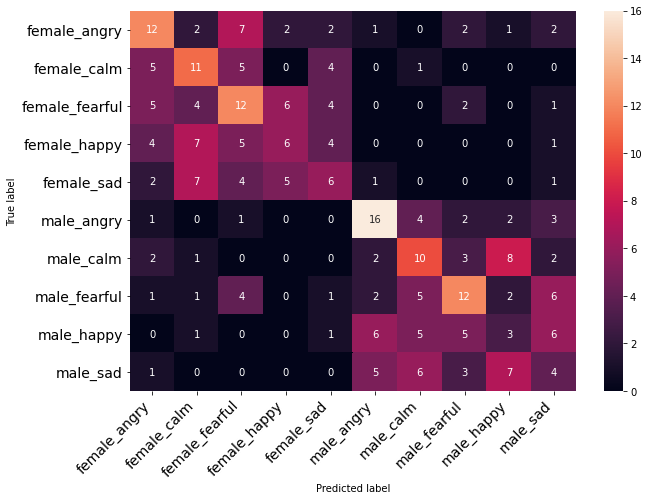

In [ ]:
# Visualize Confusion Matrix 

class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy','male_sad']


print_confusion_matrix(c, class_names)